In [41]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
train_seg_length = 100
test_seg_length = 100

routing_file = open('.routing', 'r')
Lines = routing_file.readlines()

# List of parsed logfiles
keyboard = []
mouse = []

for line in Lines:
    line = line.strip()
    if 'key.log' in line:
        keyboard.append(parse_keyboard_log(line))
    elif 'mouse.log' in line:
        mouse.append(parse_mouse_log(line))

# Split into train and test sets
X_train = []
X_test = []
Y_train = []
Y_test = []

for k in range(len(keyboard) - 1):
    for i in range(int(keyboard[k].time.iloc[-1] / train_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, train_seg_length)
        heatmap = heatmap.to_binary_class_label("MITSOL")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_train.append(heatmap.heatmap_data().ravel().tolist())
            Y_train.append(heatmap.class_label())

for k in range(len(keyboard) - 1,len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / test_seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, test_seg_length)
        heatmap = heatmap.to_binary_class_label("MITSOL")
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_test.append(heatmap.heatmap_data().ravel().tolist())
            Y_test.append(heatmap.class_label())

print(f"Train samples: {len(Y_train)}")
print(f"Test samples: {len(Y_test)}")

Train samples: 181
Test samples: 36


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( f"Train score: {rfc.score(X_train, Y_train)} " + f"Test score: {rfc.score(X_test, Y_test)}")

Train score: 1.0 Test score: 0.8333333333333334


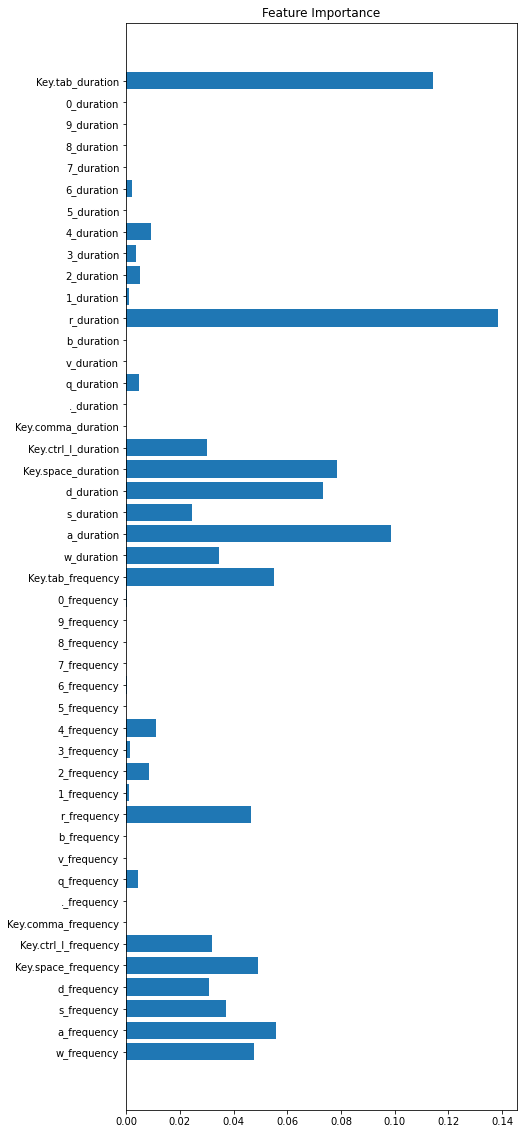

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
#indices = np.argsort(importances)

# Expand figure vertically
plt.figure(figsize=(7,20))

# Barplot
plt.barh(range(len(importances)), importances)
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(importances)), KeyboardHeatmap.heatmap_data_names())
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(465.0, 570.4444444444445, 'Key.ctrl_l_duration <= 0.045\ngini = 0.332\nsamples = 118\nvalue = [143, 38]'),
 Text(420.7142857142857, 503.3333333333333, 'Key.tab_duration <= 0.283\ngini = 0.444\nsamples = 74\nvalue = [76, 38]'),
 Text(376.42857142857144, 436.22222222222223, 'r_duration <= 0.121\ngini = 0.498\nsamples = 46\nvalue = [33, 38]'),
 Text(221.42857142857142, 369.1111111111111, 'd_duration <= 0.628\ngini = 0.411\nsamples = 27\nvalue = [32, 13]'),
 Text(132.85714285714286, 302.0, 'a_duration <= 0.8\ngini = 0.175\nsamples = 17\nvalue = [28, 3]'),
 Text(88.57142857142857, 234.88888888888886, 'a_frequency <= 0.19\ngini = 0.067\nsamples = 15\nvalue = [28, 1]'),
 Text(44.285714285714285, 167.77777777777777, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(132.85714285714286, 167.77777777777777, 'gini = 0.0\nsamples = 14\nvalue = [28, 0]'),
 Text(177.14285714285714, 234.88888888888886, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(310.0, 302.0, 'd_frequency <= 0.155\ngini = 

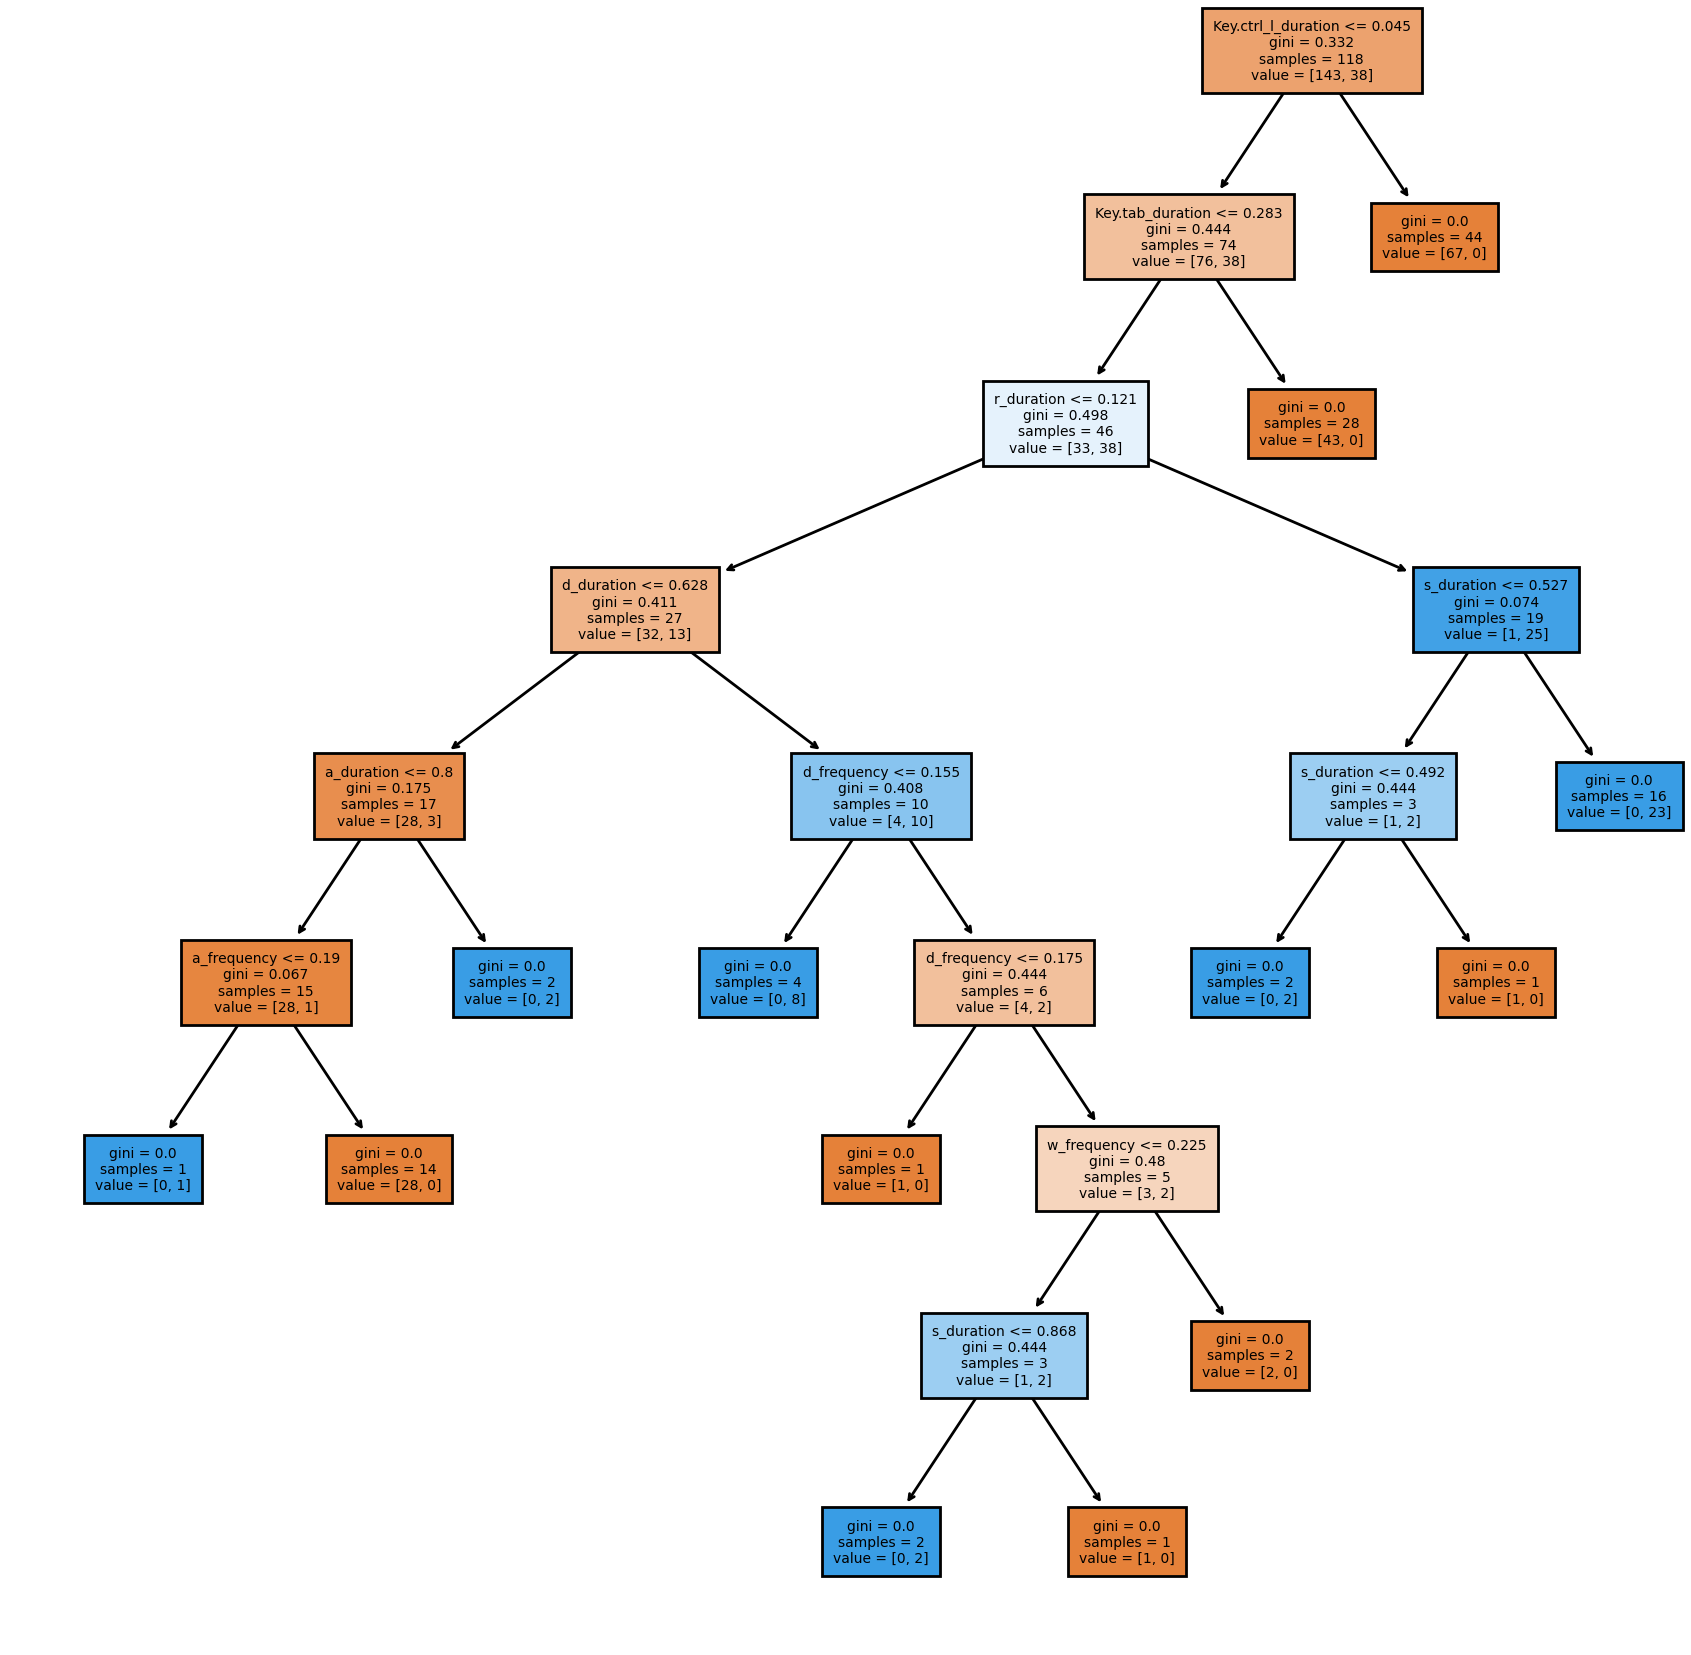

In [44]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], fontsize=5,feature_names = KeyboardHeatmap.heatmap_data_names(),filled = True)